In [1]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "32"
os.environ["OMP_NUM_THREADS"] = "1"


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvn
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances

import codpy.core
from codpy.kernel import Kernel
from codpy.multiscale_kernel import MultiScaleOT
from codpy.permutation import lsap
from codpy.plot_utils import multi_plot
from codpy.clustering import GreedySearch

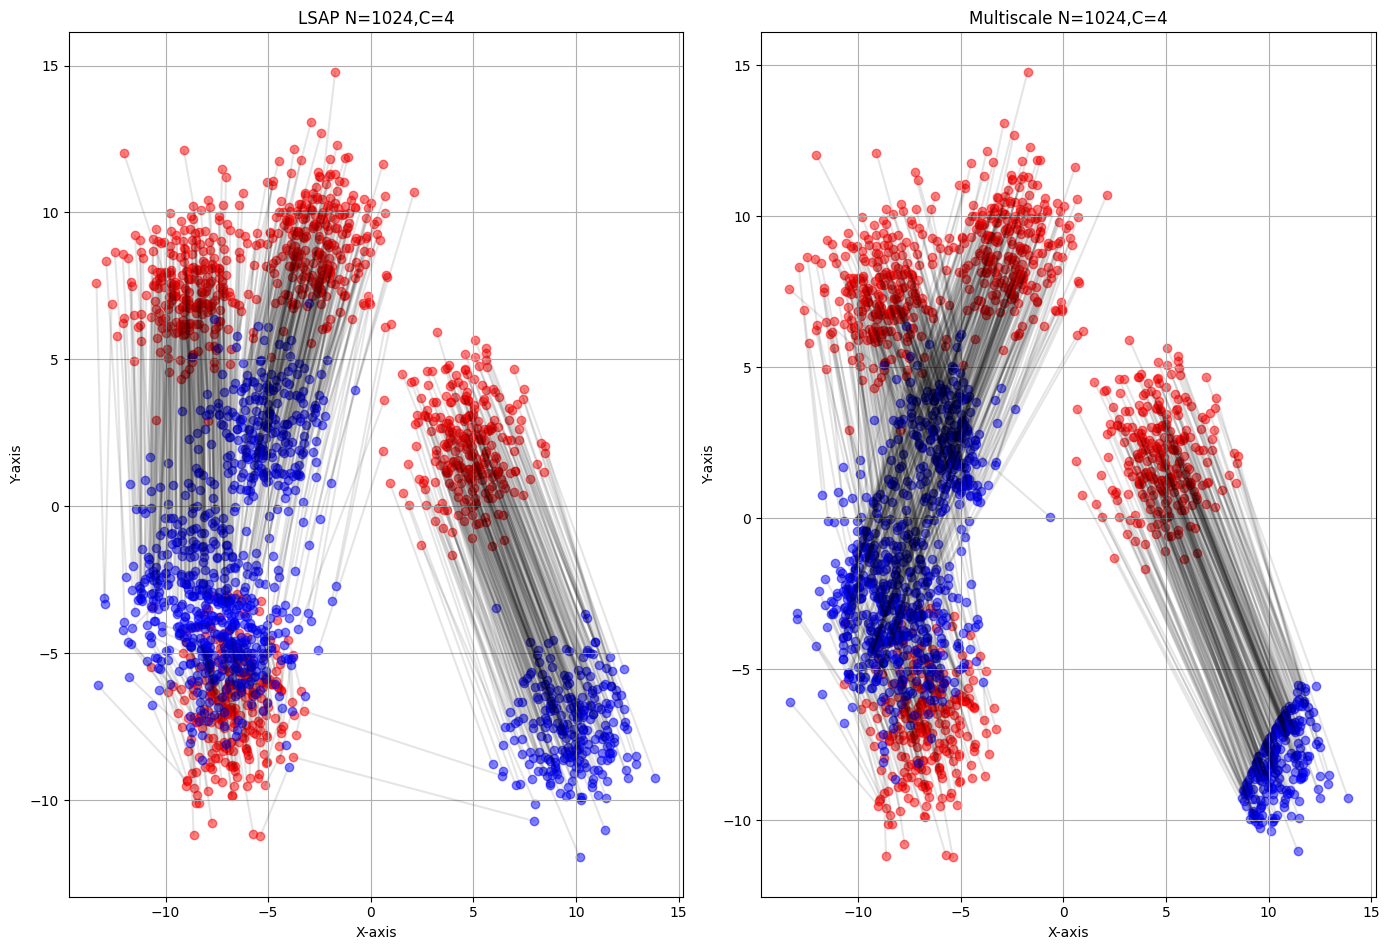

In [2]:
def clusters_fig(Ns=[1024], Cs=[4]):

    results,legends = [],[]

    def one_experiment(N,D,C):
        X1, _ = make_blobs(n_samples=N, n_features=2,centers=C, random_state=42, cluster_std=1.5)
        X2, _ = make_blobs(n_samples=N, n_features=2,centers=C, random_state=84, cluster_std=1.5)
        # MS = MultiScaleOT(C,method = GreedySearch)
        MS = MultiScaleOT(C)
        MS.set(X1, X2, max_nystrom = 100000)
        Yref = X2[lsap(MS.MB1.distance(x=X2,y=X1))]
        Yms = MS(X1)
        return (X1,Yref,Yms)


    results=[]

    for N in Ns:
            for C in Cs:
                X1,Yref,Yms = one_experiment(N,2,C)
                results.append([X1,Yref])
                results.append([X1,Yms])
    
    def plot_clusters(data, ax, legend="", **kwargs):
        X1,Yref = data
        ax.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.5, label="X")
        ax.scatter(Yref[:, 0], Yref[:, 1], color='blue', alpha=0.5, label="Y")
        for i in range(X1.shape[0]):
            ax.plot([X1[i,0],Yref[i,0]],[X1[i,1],Yref[i,1]],color='black', label="LSAP",alpha=0.1)

        ax.set_title(f"N={X1.shape[0]},D={X1.shape[1]}")
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.grid(True)
        ax.title.set_text(legend)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
    def helper(n,c): 
        legends.append("LSAP N="+str(n)+",C="+str(c))
        legends.append("Multiscale N="+str(n)+",C="+str(c))
    [helper(Ns[n],Cs[c]) for n in range(len(Ns)) for c in range(len(Cs))]

    multi_plot(
        results,
        plot_clusters,
        mp_nrows=1,
        mp_ncols=2,
        mp_figsize=(14, 10),
        legends=legends,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# %% [markdown]
# The training set is `x,fx`, the test set is `z,fz`.
codpy.core.kernel_interface.set_verbose()
clusters_fig()